In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

import sys, os
sys.path.insert(0, '..')
from lib import graph, coarsening, utils

import torch
import numpy as np
import time

# print(torch.cuda.device_count())
# torch.cuda.set_device(3)

%matplotlib inline

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


# Arguments and Graph

Exception reporting mode: Verbose
3198 > 3136 edges
Layer 0: M_0 = |V| = 944 nodes (160 added),|E| = 3198 edges
Layer 1: M_1 = |V| = 472 nodes (64 added),|E| = 1415 edges
Layer 2: M_2 = |V| = 236 nodes (22 added),|E| = 656 edges
Layer 3: M_3 = |V| = 118 nodes (5 added),|E| = 322 edges
Layer 4: M_4 = |V| = 59 nodes (0 added),|E| = 154 edges
Execution time: 0.57s


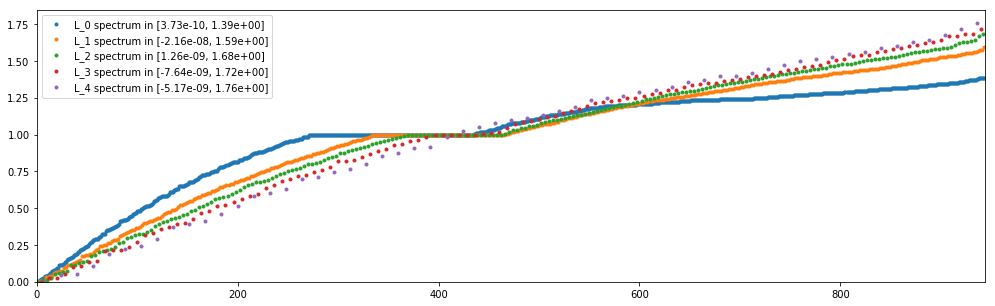

In [2]:
%reload_ext autoreload
import argparse
%xmode
sys.argv=['']
parser = argparse.ArgumentParser(description='Implementation of Graph CNN for MNIST pytorch version')
# Graphs.
parser.add_argument('--number_edges', type=int, default=8,
                    help='Graph: minimum number of edges per vertex. default=8')
# TODO: change cgcnn for combinatorial Laplacians.
parser.add_argument('--metric', type=str, default='euclidean', 
                    help='Graph: similarity measure (between features). default=euclidean')
parser.add_argument('--normalized_laplacian', type=bool, default=True, 
                    help='Graph Laplacian: normalized. default=True')
parser.add_argument('--coarsening_levels', type=int, default=4, 
                    help='Number of coarsened graphs. default=4')
# Directories.
parser.add_argument('--dir_data', type=str, default=os.path.join('..', 'data', 'mnist'), 
                    help='Directory to store data. default=os.path.join(\'..\', \'data\', \'mnist\')')

parser.add_argument('--log-interval', type=int, default=50, metavar='N',
                    help='No. of batches to wait before logging training status')

parser.add_argument('--cuda', type=bool, default=True,
                   help='Run on GPU or not. default=True')

args = parser.parse_args()


def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=args.number_edges, metric=args.metric)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))

    print("{} > {} edges".format(A.nnz//2, args.number_edges*m**2//2))
    return A

t_start = time.process_time()
A = grid_graph(28, corners=False)
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=args.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
graph.plot_spectrum(L)
del A

# Data

In [3]:
%reload_ext autoreload
from torchvision import datasets, transforms
from torch.autograd import Variable
kwargs ={'num_workers': 1, 'pin_memory': True} if args.cuda else {}

t_start = time.process_time()
print('Coarsening...')
trainset = datasets.MNIST('./data/MNIST', train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)),
                              lambda x: x.view(1,-1).numpy(),
                              lambda x: coarsening.perm_data(x, perm),
                              torch.from_numpy
                          ]))

testset = datasets.MNIST('./data/MNIST', train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,)),
                             lambda x: x.view(1,-1).numpy(),
                             lambda x: coarsening.perm_data(x, perm),
                             torch.from_numpy
                         ]))
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#del perm

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=1000, shuffle=True, **kwargs)

print('Loader done.')

Coarsening...
Execution time: 0.03s
Loader done.


# Model init

In [4]:
from model_pytorch import CGCNN_Net

common = {}
common['dir_name']       = 'mnist/'
# common['num_epochs']     = 20
common['batch_size']     = 100
# common['decay_steps']    = mnist.train.num_examples / common['batch_size']
common['eval_frequency'] = 600 # 30 * common['num_epochs']
common['bias']          = 'bias1'
common['pool']           = 'maxpool'
# Common hyper-parameters for LeNet5-like networks.
common['regularization'] = 5e-4
# common['dropout']        = 0.5
common['learning_rate']  = 0.02
# 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.001
common['momentum']       = 0.9
common['F']              = [32, 64]
common['K']              = [5, 5]
common['p']              = [4, 4]
common['M']              = [L[-1].shape[0],512, 10]

model = CGCNN_Net(L, **common)
model.double().cuda()

CGCNN_Net(
  (linear_chebyshev): ModuleList(
    (0): Linear(in_features=5, out_features=32)
    (1): Linear(in_features=160, out_features=64)
  )
  (fc_hidden): Linear(in_features=3776, out_features=512)
  (fc_output): Linear(in_features=512, out_features=10)
)

# Training and Test

In [5]:
from torch.autograd import Variable
from torch.nn import functional as F
from tensorboardX import SummaryWriter

writer = SummaryWriter()
optimizer = torch.optim.SGD(model.parameters(),    
                            lr=model.learning_rate, 
                            momentum=model.momentum,
                            weight_decay=model.decay_rate)

def train(epoch):
    model.train()
    t_process, t_wall = time.process_time(), time.time()
    loader_len = len(train_loader)
    for batch_idx, (data, target) in enumerate(train_loader):
        n_iter = (epoch * loader_len) + batch_idx
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)        
        loss.backward()
        optimizer.step()
        writer.add_scalar('Loss', loss.data[0], n_iter)
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx+50) * len(data), len(train_loader.dataset),
                100. * (batch_idx+50) / loader_len, loss.data[0])) 

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    dataset_len = len(test_loader.dataset)
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        # sum up batch loss
        test_loss += F.cross_entropy(output, target, size_average=False).data[0]
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= dataset_len
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, dataset_len, 100. * correct / dataset_len))
    writer.add_scalar('Accuracy', 100. * correct / dataset_len, epoch)
for epoch in range(1, 20 + 1):
    train(epoch)
    test(epoch)

writer.close()

Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.297289
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.516440
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.504873
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.287450
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.189899
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.103529
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.092117
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.109959
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.166766
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.067583
Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.113564
Train Epoch: 1 [60000/60000 (100%)]	Loss: 0.326660

Test set: Average loss: 0.1229, Accuracy: 9644/10000 (96%)

Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.121069
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.093564
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.061331
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.069173
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.155452
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.112333
Train Epoch: 2 [35000/60000 (58%)]	Loss: 0

Train Epoch: 13 [30000/60000 (50%)]	Loss: 0.007178
Train Epoch: 13 [35000/60000 (58%)]	Loss: 0.008988
Train Epoch: 13 [40000/60000 (67%)]	Loss: 0.024632
Train Epoch: 13 [45000/60000 (75%)]	Loss: 0.014352
Train Epoch: 13 [50000/60000 (83%)]	Loss: 0.019953
Train Epoch: 13 [55000/60000 (92%)]	Loss: 0.029577
Train Epoch: 13 [60000/60000 (100%)]	Loss: 0.019997

Test set: Average loss: 0.0530, Accuracy: 9832/10000 (98%)

Train Epoch: 14 [5000/60000 (8%)]	Loss: 0.019135
Train Epoch: 14 [10000/60000 (17%)]	Loss: 0.010689
Train Epoch: 14 [15000/60000 (25%)]	Loss: 0.002451
Train Epoch: 14 [20000/60000 (33%)]	Loss: 0.017635
Train Epoch: 14 [25000/60000 (42%)]	Loss: 0.045718
Train Epoch: 14 [30000/60000 (50%)]	Loss: 0.011219
Train Epoch: 14 [35000/60000 (58%)]	Loss: 0.015925
Train Epoch: 14 [40000/60000 (67%)]	Loss: 0.128208
Train Epoch: 14 [45000/60000 (75%)]	Loss: 0.010757
Train Epoch: 14 [50000/60000 (83%)]	Loss: 0.009629
Train Epoch: 14 [55000/60000 (92%)]	Loss: 0.013004
Train Epoch: 14 [60000